In [240]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, DataLoader

In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("qingyi/wm811k-wafer-map")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/qingyi/wm811k-wafer-map/versions/1


In [34]:
with open('/root/.cache/kagglehub/datasets/qingyi/wm811k-wafer-map/versions/1/LSWMD.pkl', 'rb') as f:
    raw_data = pd.read_pickle(f)

print(raw_data)

                                                 waferMap  dieSize   lotName  \
0       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0      lot1   
1       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0      lot1   
2       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0      lot1   
3       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0      lot1   
4       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0      lot1   
...                                                   ...      ...       ...   
811452  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...    600.0  lot47542   
811453  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...    600.0  lot47542   
811454  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...    600.0  lot47542   
811455  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...    600.0  lot47543   
811456  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...    600.0  lot47543   

        waferIndex trianTestLabel    fa

In [232]:
raw_data.rename(columns={'trianTestLabel': 'trainTestLabel'}, inplace=True)
wafer_data = raw_data[raw_data['trainTestLabel'].str.len() != 0]

columns_to_drop = ['dieSize','lotName','waferIndex','trainTestLabel']

wafer_data = wafer_data.drop(columns = columns_to_drop)
print(wafer_data)

                                                 waferMap    failureType
0       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       [[none]]
1       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       [[none]]
2       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       [[none]]
3       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       [[none]]
4       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       [[none]]
...                                                   ...            ...
811450  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...   [[Edge-Loc]]
811451  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...   [[Edge-Loc]]
811452  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...  [[Edge-Ring]]
811453  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...   [[Edge-Loc]]
811454  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...  [[Edge-Ring]]

[172950 rows x 2 columns]


In [233]:
defect_classes = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']
num_classes = len(defect_classes)

<class 'numpy.ndarray'>


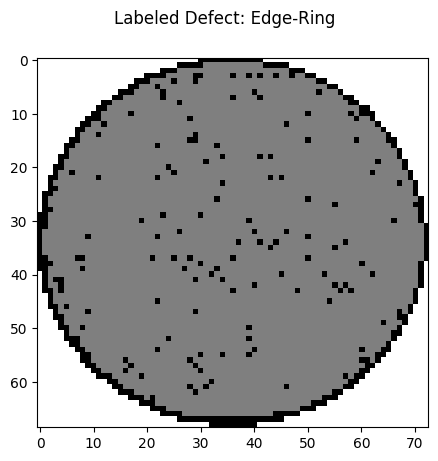

In [234]:
print(type(wafer_data.iloc[0]['waferMap']))
printWaferMap(wafer_data.iloc[10000])

In [235]:
# Print class distribution
describeWaferData(wafer_data, defect_classes)

Center: 4294
Donut: 555
Edge-Loc: 5189
Edge-Ring: 9680
Loc: 3593
Near-full: 149
Random: 866
Scratch: 1193
none: 147431


In [238]:
for defect_type in defect_classes:
  if defect_type == 'none':
    break
  print(defect_type)
  augmentation = pd.DataFrame(oversampleData(wafer_data, defect_type))
  wafer_data = pd.concat([wafer_data.reset_index(drop=True), pd.DataFrame(augmentation).reset_index(drop=True)], ignore_index=True)

Center
Donut
Edge-Loc
Edge-Ring
Loc
Near-full
Random
Scratch


In [239]:
# Assess Data Augmentation
describeWaferData(wafer_data, defect_classes)

Center: 25764
Donut: 3330
Edge-Loc: 31134
Edge-Ring: 58080
Loc: 21558
Near-full: 894
Random: 5196
Scratch: 7158
none: 147431


In [247]:
train_size = int(0.8 * len(wafer_data))
val_size = int(0.1 * len(wafer_data))
test_size = len(wafer_data) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(wafer_data, [train_size, val_size, test_size])

In [248]:
# This cell is where I will be implementing the convnet

In [237]:
def oversampleData(wafers, defect_type):
  temp_df = wafers.copy()
  temp_df.drop(temp_df.index, inplace = True)
  for index, rows in wafers.loc[wafers['failureType'] == defect_type].iterrows():
    temp_wafer_ud = rows
    temp_wafer_ud['waferMap'] = np.flip(temp_wafer_ud['waferMap'], 0)
    temp_df.loc[len(temp_df)] = temp_wafer_ud

    temp_wafer_lr = rows
    temp_wafer_lr['waferMap'] = np.flip(temp_wafer_lr['waferMap'], 0)
    temp_df.loc[len(temp_df)] = temp_wafer_lr

    temp_wafer_90 = rows
    temp_wafer_90['waferMap'] = np.rot90(temp_wafer_90['waferMap'], 1)
    temp_df.loc[len(temp_df)] = temp_wafer_90

    temp_wafer_180 = rows
    temp_wafer_180['waferMap'] = np.rot90(temp_wafer_180['waferMap'], 1)
    temp_df.loc[len(temp_df)] = temp_wafer_180

    temp_wafer_270 = rows
    temp_wafer_270['waferMap'] = np.rot90(temp_wafer_270['waferMap'], 1)
    temp_df.loc[len(temp_df)] = temp_wafer_270

  return temp_df
  pass

In [122]:
def describeWaferData(wafer_data, classes):
  for classType in classes:
    count = (wafer_data['failureType'] == classType).sum()
    print(classType + ": " + str(count))

In [105]:
def printWaferMap(wafer, prediction = ""):
  # Generate a plot using the binary colormap
  # Wafer area is indicated by grey, defects are indicated in black
  wafer_map = wafer['waferMap']
  plt.imshow(wafer_map, cmap='binary', interpolation='nearest')

  plt.suptitle("Labeled Defect: " + str(wafer['failureType'][0][0]))

  plt.show()
  pass